# Steady State Multiplicity in n-heptane/air Mixtures

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- Solving for the steady ignition and extinction trajectories of a heptane-air mixture, which show the existence of multiple steady states and path-dependence
- Observing the sensitivity of ignition/extinction behavior to temperature and stoichiometry

## Introduction

An interesting feature of combustion chemistry is that the balance of homogeneous chemistry and transport processes (most often molecular mixing) can take many forms. In an open homogeneous reactor with a particular residence time, this means that multiple steady states can exist for the same residence time - depending on "how you got there."

In this demo we show this for a mixture of n-heptane and air. We're effectively performing continuation in the residence time, starting at a very low value (very intense flow), letting the mixture equilibrate, and then slightly giving the reactor more residence time. As we go, eventually the mixture will be able to sustain chain branching chemistry and ignite. Approaching an infinite residence time corresponds to reaching the unperturbed chemical equilibrium state.

We just computed the ignition branch - to compute the extinction branch we simply go backwards and  very slowly take the residence time to zero. At some point the chemistry will not be able to sustain losses to the flow and the flame will extinguish. When the residence time gets to zero, we'll simply see the reactor outflow be exactly the feed stream - there is no time for chemistry to occur.

The interesting feature here is that the critical residence time for ignition is _not_ the same as the critical value for extinction. It takes more dissipation through transport mechansims to extinguish a flame than what will admit ignition. In a way it makes sense - ignition fundamentally alters the mixture by providing a pool of radical species, after which extinction requires those to be removed faster than they are produced.

In [1]:
from spitfire import ChemicalMechanismSpec, HomogeneousReactor
import matplotlib.pyplot as plt
import numpy as np

mech = ChemicalMechanismSpec('heptane-liu-hewson-chen-pitsch-highT.yaml', 'gas')

So that we could easily run different chemistries, temperatures, pressures, etc., a function that returns the ignition and extinction branches is helpful. The steady temperature is provided, but mass fractions of certain species, explosive eigenvalues, reaction rates, and more could all be post-processed and observed in addition.

In [2]:
def get_trajectories(mech, T, P, fuel, phi, tau_values):
    tau_list = np.hstack([tau_values, tau_values[::-1]])
    T_list = np.zeros_like(tau_list)

    mix = mech.mix_for_equivalence_ratio(phi, mech.stream('X', fuel), mech.stream(stp_air=True))
    mix.TP = T, P
    feed = mech.copy_stream(mix)

    for idx, tau in enumerate(tau_list):
        r = HomogeneousReactor(mech, mix, 
                               'isobaric',
                               'adiabatic', 
                               'open', 
                               mixing_tau=tau, 
                               feed_temperature=feed.T,
                               feed_mass_fractions=feed.Y)
        output = r.integrate_to_steady(steady_tolerance=1e-8)
        T_list[idx] = output['temperature'][-1]
        mix.TPY = r.current_temperature, r.current_pressure, r.current_mass_fractions
    
    return tau_list, T_list

## Ignition/Extinction Branches of stoichiometric n-heptane/air at 1000 K, 1 atm

To show the presence of ignition and extinction, and the presence of multiple steady states for a range of $\tau_{\rm mix}$, we simply show the steady reactor temperature over the residence time, for both the ignition and extinction branches.

In [3]:
ntau = 100
tau_values = np.logspace(-8, 2, ntau)

tau_list, T_list = get_trajectories(mech, 1000., 101325., 'NXC7H16:1', 1.0, tau_values)

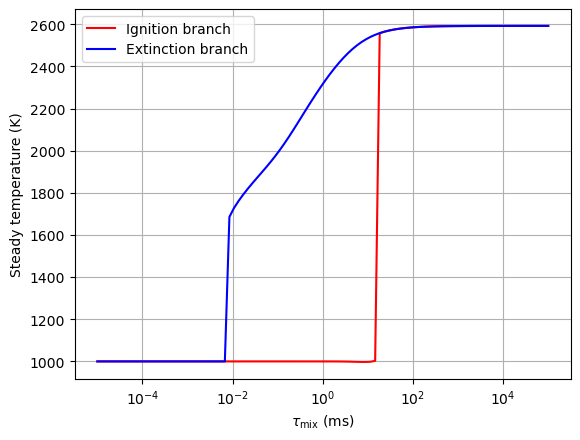

In [4]:
plt.semilogx(tau_list[:ntau] * 1.e3, T_list[:ntau], 'r', label='Ignition branch')
plt.semilogx(tau_list[ntau:] * 1.e3, T_list[ntau:], 'b', label='Extinction branch')
plt.xlabel('$\\tau_{\\rm mix}$ (ms)')
plt.ylabel('Steady temperature (K)')
plt.grid()
plt.legend()
plt.show()

## Dependence on Temperature

Now we simply take the above analysis for stoichiometric mixtures and repeat it for a range of temperatures.

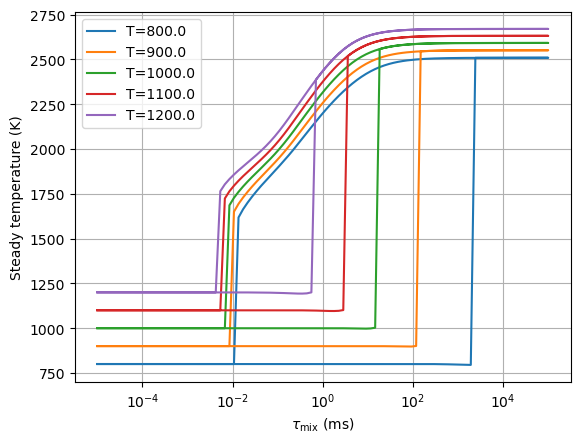

In [5]:
for T in [800, 900, 1000, 1100, 1200]:
    tau_list, T_list = get_trajectories(mech, T, 101325., 'NXC7H16:1', 1.0, tau_values)
    plt.semilogx(tau_list * 1.e3, T_list, label=f'T={T:.1f}')
plt.xlabel('$\\tau_{\\rm mix}$ (ms)')
plt.ylabel('Steady temperature (K)')
plt.grid()
plt.legend()
plt.show()

An interesting observation here is that while the ignition point is highly sensitive to temperature, the extinction behavior is much more consistent.

## Dependence on Equivalence Ratio

Now we'll see how varying the equivalence ratio affects ignition/extinction.

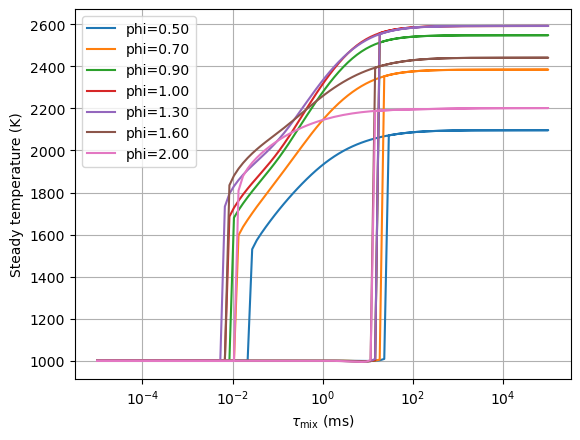

In [6]:
for phi in [0.5, 0.7, 0.9, 1.0, 1.3, 1.6, 2.0]:
    tau_list, T_list = get_trajectories(mech, 1000., 101325., 'NXC7H16:1', phi, tau_values)
    plt.semilogx(tau_list * 1.e3, T_list, label=f'phi={phi:.2f}')
plt.xlabel('$\\tau_{\\rm mix}$ (ms)')
plt.ylabel('Steady temperature (K)')
plt.grid()
plt.legend()
plt.show()

Interestingly, sensitivity to stoichiometry is almost nonexistent in the critical residence times for ignition and extinction. An important caveat at this point is that this chemical mechanism could be reduced in size and optimized for a limited range of temperatures, pressures, equivalence ratios, and combustion regimes (e.g., nonpremixed vs premixed/homogeneous).

## Conclusions

In this notebook we've generated a number of ignition-extinction trajectories for mixtures of n-heptane and air, and observed the sensitivity of the steady state multiplicity to temperature and stoichiometry.